In [1]:
from sagemaker import get_execution_role
from sagemaker import Session
role = get_execution_role()
sess = Session()
bucket = sess.default_bucket()

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential
# keras.backend.set_image_data_format('channels_first')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
x = digits.images
y = digits.target

In [5]:
x.shape

(1797, 8, 8)

In [6]:
y.shape

(1797,)

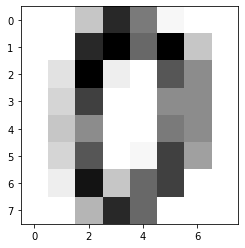

In [7]:
plt.imshow(x[0], cmap='Greys')

In [8]:
x[0].reshape(-1,)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [9]:
X_flat = x.reshape(x.shape[0], -1)

In [10]:
X_flat.shape

(1797, 64)

In [11]:
# Sanity Check
all(digits['data'][0] == X_flat[0])

True

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore')
y_ohe = ohe.fit_transform(y.reshape(-1,1))
print('y_ohe shape' ,y_ohe.shape)
print('y_ohe categories ',ohe.categories_)

y_ohe shape (1797, 10)
y_ohe categories  [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]


In [13]:
seed = 26
Test_Size = int(X_flat.shape[0] * .15)
Test_Size

269

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_ohe, test_size=Test_Size, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=Test_Size, random_state=seed)

print(f"Train\n\tX {X_train.shape}\n\tY {y_train.shape}")
print(f"Validation\n\tX {X_val.shape}\n\tY {y_val.shape}")
print(f"Test\n\tX {X_test.shape}\n\tY {y_test.shape}")

Train
	X (1259, 64)
	Y (1259, 10)
Validation
	X (269, 64)
	Y (269, 10)
Test
	X (269, 64)
	Y (269, 10)


In [15]:
# Check the max values in each image array.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(16.0, 16.0, 16.0)

In [16]:
# Scaling data.
X_train, X_test, X_val = X_train / 16, X_test / 16, X_val / 16

In [17]:
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(1.0, 1.0, 1.0)

In [18]:
model = Sequential()

In [19]:
# Adding an input layer.
model.add(
    layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1])
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
# Adding an output layer.
model.add(
    layers.Dense(units=10, activation='softmax')
    )

In [21]:
# Compile model with an optimizer, loss function, and preferred metrics.
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train)

Train on 1259 samples
1259/1259 [==============================] - 0s 202us/sample - loss: 2.3453 - acc: 0.1136


In [24]:
model.predict(X_train[[0]])

array([[0.0971551 , 0.08611872, 0.11303982, 0.11258152, 0.08557583,
        0.09595751, 0.10832487, 0.09619025, 0.11344484, 0.09161156]],
      dtype=float32)

In [25]:
np.argmax(model.predict(X_train[[0]]), axis=1)

array([8])

In [26]:
predictions_df = pd.DataFrame(
    zip(ohe.categories_[0], model.predict(X_test[[0]])[0]),
    columns=['Target', 'Softmax']
    )
predictions_df

,Target,Softmax
0,0,0.100137
1,1,0.101171
2,2,0.099367
3,3,0.098718
4,4,0.101002
5,5,0.099310
6,6,0.099561
7,7,0.100250
8,8,0.098963
9,9,0.101521


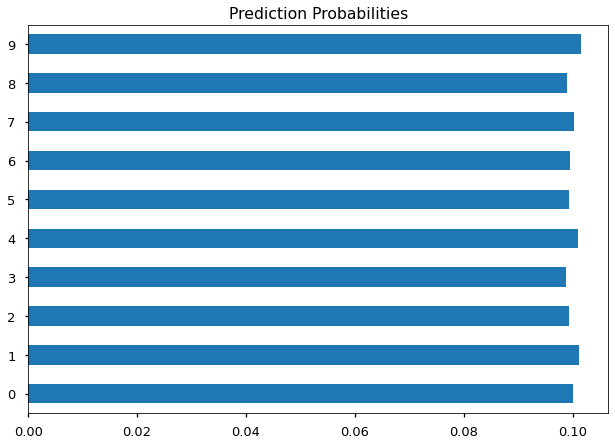

In [27]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots()
    predictions_df['Softmax'].plot(kind='barh')
    ax.set(title='Prediction Probabilities')

In [28]:
# Functionalizing the above.
def plot_prediction_probabilities(trained_model, encoder, entry):
    """
    Show a bar chart representing prediction probabilities.
    """
    
    predictions_df = pd.DataFrame(
        zip(encoder.categories_[0], trained_model.predict(entry)[0]),
        columns=['Target', 'Softmax']
        )
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots()
        predictions_df['Softmax'].plot(kind='barh')
        ax.set(title='Prediction Probabilities')
        plt.show()

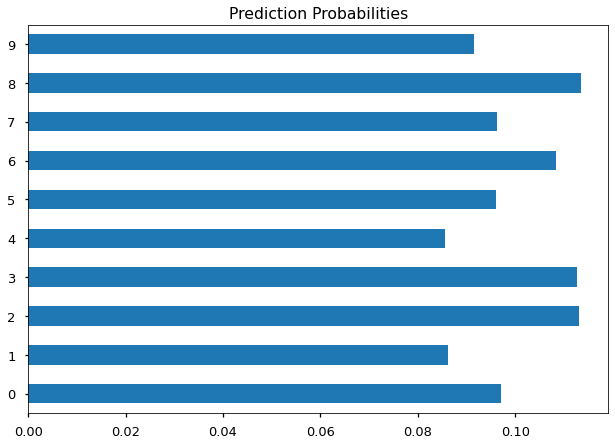

In [29]:
plot_prediction_probabilities(model, ohe, X_train[[0]])

In [30]:
model.fit(X_train, y_train, validation_data=(X_val, y_val))

Train on 1259 samples, validate on 269 samples
1259/1259 [==============================] - 0s 170us/sample - loss: 2.3060 - acc: 0.1239 - val_loss: 2.3045 - val_acc: 0.1152


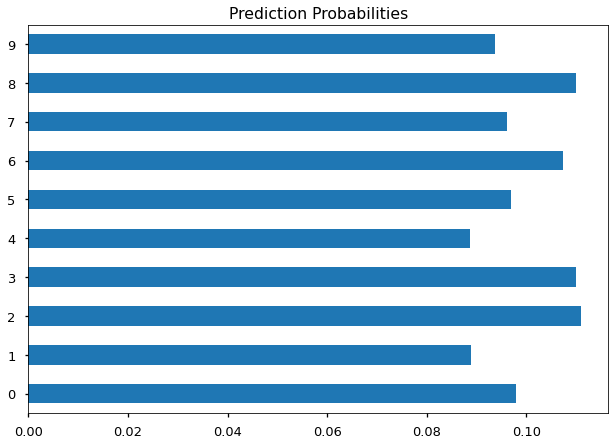

In [31]:
plot_prediction_probabilities(model, ohe, X_train[[0]])

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Train on 1259 samples, validate on 269 samples
Epoch 1/5
1259/1259 [==============================] - 0s 99us/sample - loss: 2.2930 - acc: 0.1525 - val_loss: 2.2790 - val_acc: 0.1413
Epoch 2/5
1259/1259 [==============================] - 0s 100us/sample - loss: 2.2642 - acc: 0.1525 - val_loss: 2.2516 - val_acc: 0.1152
Epoch 3/5
1259/1259 [==============================] - 0s 116us/sample - loss: 2.2403 - acc: 0.1374 - val_loss: 2.2288 - val_acc: 0.1115
Epoch 4/5
1259/1259 [==============================] - 0s 98us/sample - loss: 2.2190 - acc: 0.1319 - val_loss: 2.2088 - val_acc: 0.1152
Epoch 5/5
1259/1259 [==============================] - 0s 99us/sample - loss: 2.1995 - acc: 0.1326 - val_loss: 2.1906 - val_acc: 0.1152


In [33]:
history

In [34]:
history.history

{'loss': [2.2929571777037725,
  2.264168158327425,
  2.2402669069215926,
  2.2189697815938256,
  2.199509165417684],
 'acc': [0.15250199, 0.15250199, 0.13741064, 0.13185067, 0.13264495],
 'val_loss': [2.2790223444261515,
  2.251604741390753,
  2.2287515069472303,
  2.208844405567779,
  2.190569300633824],
 'val_acc': [0.14126395, 0.11524164, 0.111524165, 0.11524164, 0.11524164]}

In [35]:

def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

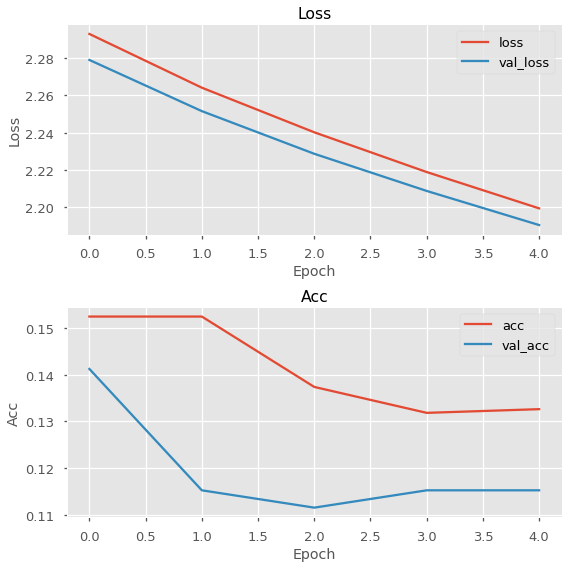

In [36]:
plot_history(history)

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Train on 1259 samples, validate on 269 samples
Epoch 1/10
1259/1259 [==============================] - 0s 100us/sample - loss: 2.1818 - acc: 0.1319 - val_loss: 2.1734 - val_acc: 0.1227
Epoch 2/10
1259/1259 [==============================] - 0s 103us/sample - loss: 2.1646 - acc: 0.1374 - val_loss: 2.1576 - val_acc: 0.1413
Epoch 3/10
1259/1259 [==============================] - 0s 99us/sample - loss: 2.1488 - acc: 0.1509 - val_loss: 2.1420 - val_acc: 0.1487
Epoch 4/10
1259/1259 [==============================] - 0s 96us/sample - loss: 2.1335 - acc: 0.1668 - val_loss: 2.1283 - val_acc: 0.1487
Epoch 5/10
1259/1259 [==============================] - 0s 102us/sample - loss: 2.1191 - acc: 0.1644 - val_loss: 2.1157 - val_acc: 0.1450
Epoch 6/10
1259/1259 [==============================] - 0s 100us/sample - loss: 2.1054 - acc: 0.1755 - val_loss: 2.1035 - val_acc: 0.1450
Epoch 7/10
1259/1259 [==============================] - 0s 98us/sample - loss: 2.0927 - acc: 0.1811 - val_loss: 2.0919 - val_ac

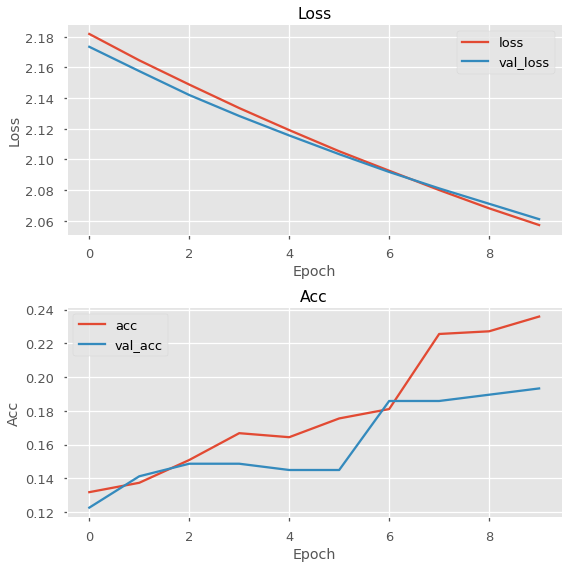

In [38]:
plot_history(history)

In [39]:
# Building a new model with a hidden layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Train on 1259 samples, validate on 269 samples
Epoch 1/10
1259/1259 [==============================] - 0s 356us/sample - loss: 2.2901 - acc: 0.0921 - val_loss: 2.2472 - val_acc: 0.1264
Epoch 2/10
1259/1259 [==============================] - 0s 127us/sample - loss: 2.2238 - acc: 0.1422 - val_loss: 2.1843 - val_acc: 0.1375
Epoch 3/10
1259/1259 [==============================] - 0s 133us/sample - loss: 2.1610 - acc: 0.1469 - val_loss: 2.1187 - val_acc: 0.1413
Epoch 4/10
1259/1259 [==============================] - 0s 117us/sample - loss: 2.0969 - acc: 0.1549 - val_loss: 2.0550 - val_acc: 0.1524
Epoch 5/10
1259/1259 [==============================] - 0s 113us/sample - loss: 2.0315 - acc: 0.1620 - val_loss: 1.9907 - val_acc: 0.1636
Epoch 6/10
1259/1259 [==============================] - 0s 110us/sample - loss: 1.9707 - acc: 0.1946 - val_loss: 1.9316 - val_acc: 0.2268
Epoch 7/10
1259/1259 [==============================] - 0s 120us/sample - loss: 1.9132 - acc: 0.2272 - val_loss: 1.8771 - val

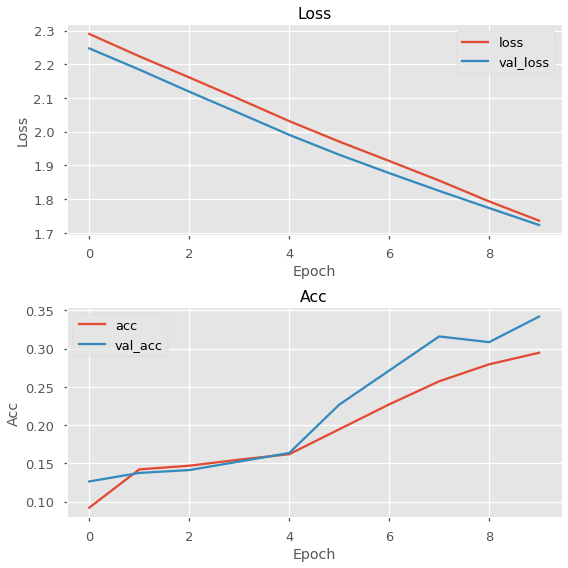

In [41]:
plot_history(history)

In [42]:

# Adding one more layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Train on 1259 samples, validate on 269 samples
Epoch 1/10
1259/1259 [==============================] - 1s 402us/sample - loss: 2.3078 - acc: 0.1199 - val_loss: 2.3001 - val_acc: 0.1078
Epoch 2/10
1259/1259 [==============================] - 0s 146us/sample - loss: 2.2841 - acc: 0.1724 - val_loss: 2.2755 - val_acc: 0.1822
Epoch 3/10
1259/1259 [==============================] - 0s 128us/sample - loss: 2.2485 - acc: 0.2343 - val_loss: 2.2321 - val_acc: 0.2342
Epoch 4/10
1259/1259 [==============================] - 0s 129us/sample - loss: 2.1812 - acc: 0.2534 - val_loss: 2.1564 - val_acc: 0.2416
Epoch 5/10
1259/1259 [==============================] - 0s 126us/sample - loss: 2.0844 - acc: 0.2716 - val_loss: 2.0544 - val_acc: 0.2491
Epoch 6/10
1259/1259 [==============================] - 0s 125us/sample - loss: 1.9573 - acc: 0.2836 - val_loss: 1.9170 - val_acc: 0.2788
Epoch 7/10
1259/1259 [==============================] - 0s 123us/sample - loss: 1.8145 - acc: 0.3503 - val_loss: 1.7636 - val

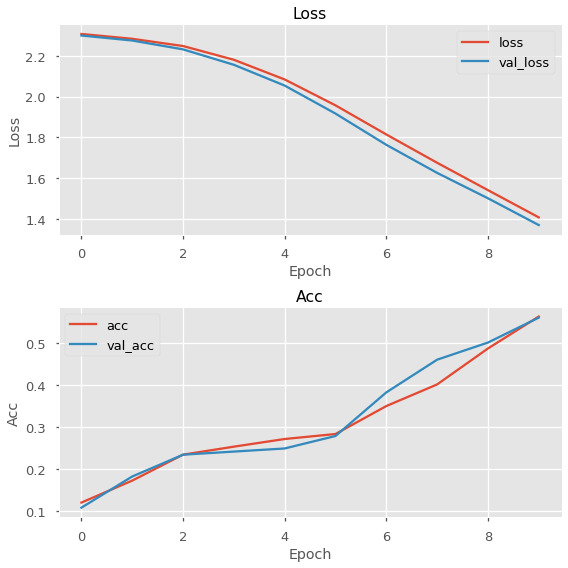

In [44]:
plot_history(history)

In [45]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [46]:
X_train.shape[0]

1259

In [47]:
# Full-batch.
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=X_train.shape[0]
    )

Train on 1259 samples, validate on 269 samples
Epoch 1/10
1259/1259 [==============================] - 0s 294us/sample - loss: 2.3051 - acc: 0.0620 - val_loss: 2.3029 - val_acc: 0.0520
Epoch 2/10


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'